In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import re
import matplotlib.pyplot as plt
import networkx as nx
import markov_clustering as mc
import matplotlib

In [1]:
import sklearn
sklearn.__version__

'0.24.2'

In [2]:
output_path = '/home/bruce1996/data/pr/0711/'

In [3]:
files = os.listdir(output_path)
file_list = list()
for f in files :
    if 'txt' not in f :
        pass
    else :
        file_list.append(output_path + f)

cluster_df = pd.DataFrame()
for file in file_list:
    df = pd.read_csv(file,sep='\t',index_col=0)
    cluster_df = pd.concat([cluster_df,df],axis=0)

cluster_df = cluster_df.drop_duplicates()
pd.DataFrame({'Name' : sorted(list(cluster_df.index) )}).to_csv('~/repo/tmp.txt',index=None,header=None)

In [4]:
cluster_go = pd.read_csv('/home/bruce1996/data/MCI/humann_Go/cluster_specific_Go.txt',sep='\t',index_col=0)
cluster_go.index.name = None
cluster_go = cluster_go.iloc[1:,:]
#cluster_go.index = [x.split('|')[0] for x in cluster_go.index]
cluster_go.columns = [x.split('_')[0] for x in cluster_go.columns]

In [5]:
go_ancester_df = pd.read_csv('/home/bruce1996/data/MCI/humann_Go/go_convert_table.txt',index_col=0,sep='\t')

go_anc_idx = np.empty(cluster_go.shape[0],dtype=object)
for idx,g in enumerate(cluster_go.index) :
    if g in go_ancester_df.index :
        go_anc_idx[idx] = go_ancester_df.loc[g,'value']
    else :
        go_anc_idx[idx] = g

In [9]:
import pickle

with open('/home/bruce1996/repo/taxa2go_dict.pkl', 'rb') as f:
    taxa2go_dict = pickle.load(f)


In [85]:
fl = os.listdir(output_path)

In [86]:
fl

['MCI-co-expression-network.png',
 'MCI-co-expression-subnetwork-s__Streptococcus_salivarius.png',
 'Subnetwork scatterplot for Cluster 6 (s__Bacteroides_eggerthii).png',
 'Normal-co-expression-subnetwork-s__Alistipes_shahii.png',
 'Overall-co-expression-subnetwork-s__Bacteroides_plebeius.png',
 'Normal-co-expression-subnetwork-s__Roseburia_intestinalis.txt',
 'Normal-co-expression-subnetwork-s__Alistipes_shahii.txt',
 'Subnetwork scatterplot for Cluster 9 (s__Paraprevotella_clara).png',
 'MCI-co-expression-subnetwork-s__Bacteroides_fluxus.txt',
 'Overall-co-expression-subnetwork-s__Roseburia_inulinivorans.png',
 'Subnetwork scatterplot for Cluster 10 (s__Roseburia_inulinivorans).png',
 'MCI-co-expression-subnetwork-s__Bacteroides_fluxus.png',
 'Normal-TSEA-scatterplot.png',
 'Overall-co-expression-subnetwork-s__Paraprevotella_clara.png',
 'Overall-TSEA-scatterplot.png',
 'Overall-co-expression-network.png',
 'Subnetwork scatterplot for Cluster 8 (s__Bacteroides_plebeius).png',
 'Overa

In [146]:
import os 

from math import log10

def apply_fx(df):
    output = log10(df['padj']) * df['taxa_coverage'] * -1
    return output

fl = os.listdir(output_path)

for f in fl :
    if 'txt' not in f or 'go_df' in f:
        pass 
    else :
        df = pd.read_csv(output_path + f,sep = '\t',index_col =0)
        s_list = list(df.index)
        go_tmp = list()
        if len(s_list) < 3 :
            pass
        else :
            for i in range(len(s_list)) :
                go_terms = list(taxa2go_dict[s_list[i]])
                go_tmp = go_tmp + go_terms
            uniq_go = list(set(go_tmp))

            go_coverage = list()
            for g in uniq_go :
                n = go_tmp.count(g) / len(s_list)
                go_coverage.append(n)
            
            go_df = go_deseq_df.loc[uniq_go,:]
            go_df['taxa_coverage'] = go_coverage
            go_df['weight'] = go_df.apply(apply_fx,axis=1)
            go_df = go_df.sort_values(by='weight',ascending=False)

            filename = output_path+ f[:-4] + '_go_df.txt'
            go_df.to_csv(filename,sep='\t')


In [148]:
fl = os.listdir(output_path)

for f in fl :
    if 'go_df' not in f :
        pass 
    else :
        print(f)

Overall-co-expression-subnetwork-s__Bacteroides_plebeius_go_df.txt
Normal-co-expression-subnetwork-s__Roseburia_intestinalis_go_df.png
Normal-co-expression-subnetwork-s__Alistipes_shahii_go_df.png
MCI-co-expression-subnetwork-s__Bacteroides_fluxus_go_df.png
MCI-co-expression-subnetwork-s__Streptococcus_salivarius_go_df.png
MCI-co-expression-subnetwork-s__Streptococcus_salivarius_go_df.txt
MCI-co-expression-subnetwork-s__Bacteroides_fluxus_go_df.txt
Normal-co-expression-subnetwork-s__Roseburia_intestinalis_go_df.txt
Overall-co-expression-subnetwork-s__Paraprevotella_clara_go_df.png
Overall-co-expression-subnetwork-s__Paraprevotella_clara_go_df.txt
Overall-co-expression-subnetwork-s__Bacteroides_plebeius_go_df.png
Normal-co-expression-subnetwork-s__Alistipes_shahii_go_df.txt


/tmp/ipykernel_3598033/3029885957.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['y'] = np.arange(20)


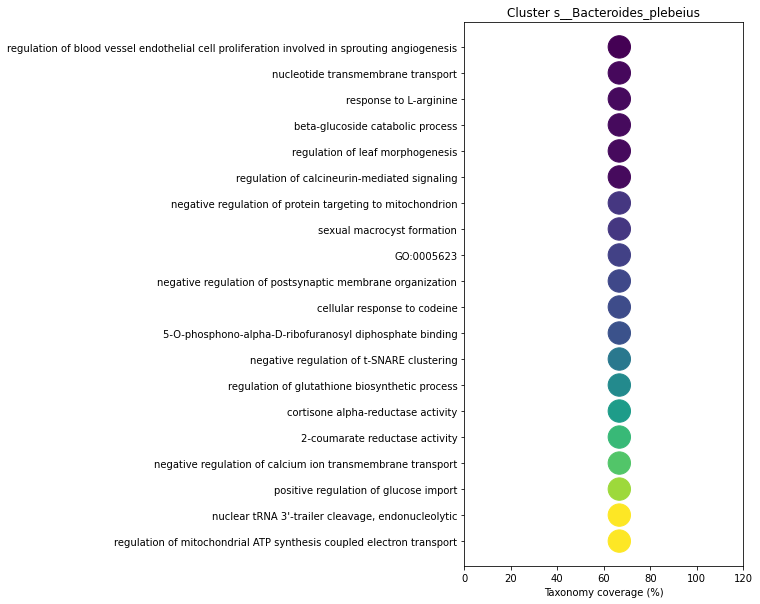

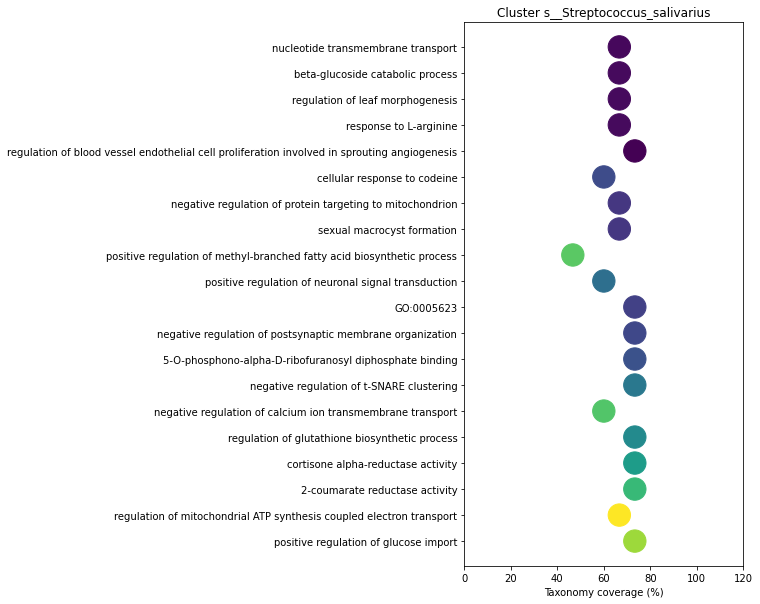

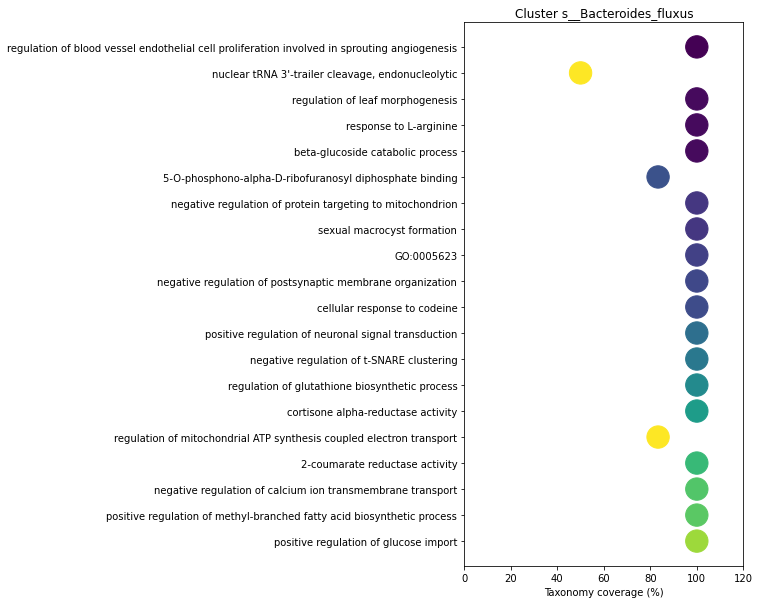

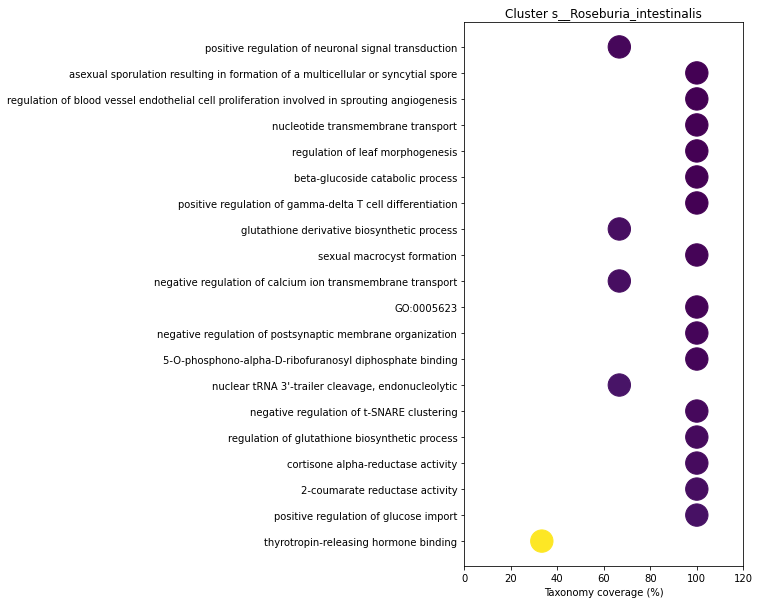

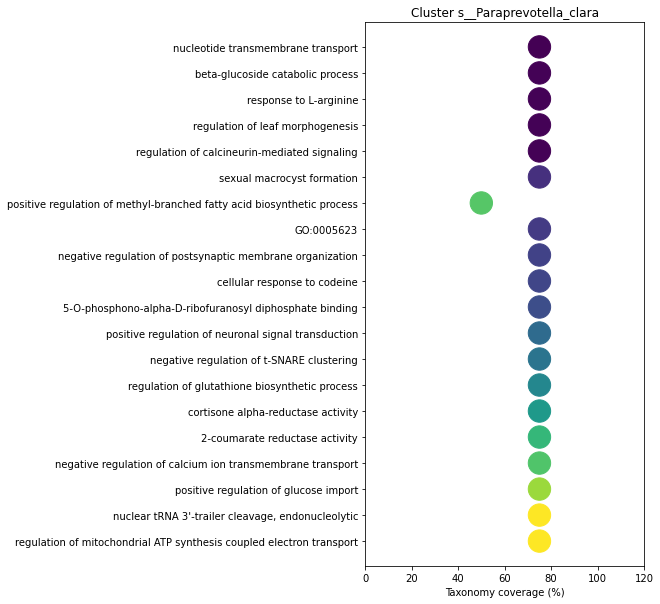

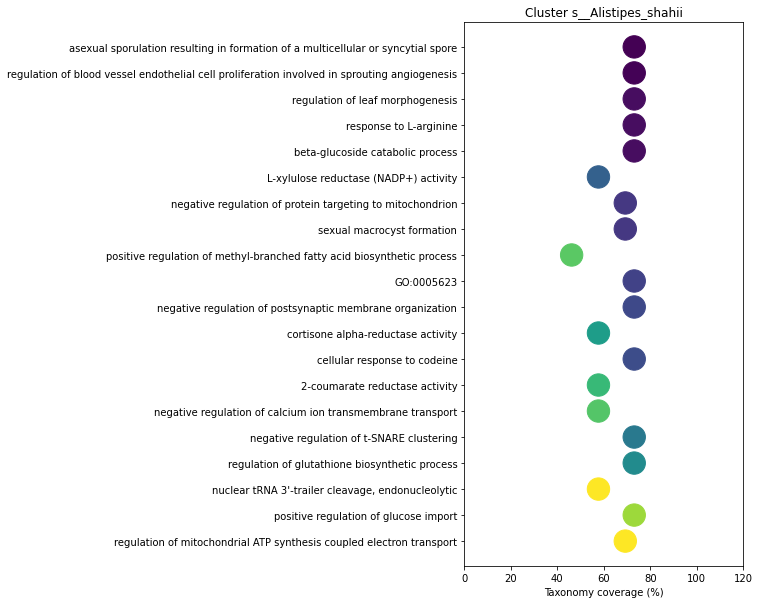

In [149]:
fl = os.listdir(output_path)

for f in fl :
    if 'go_df' not in f or '.png' in f:
        pass 
    else :
        s = f.split('-')[-1].split('_go_df')[0]
        df = pd.read_csv(output_path + f,sep='\t',index_col=0)
        title = 'Cluster ' + s
        filename = f.split('.')[0] + '.png'
        plot_go_term_barplot(df,go_term_df,title,output_path + filename)


In [118]:
go_term_df = pd.read_csv("/home/bruce1996/data/MCI/humann_Go/go_description.txt",sep = '\t',index_col=0)
go_term_df.index = go_term_df['Go']

In [141]:
output_path

'/home/bruce1996/data/pr/0711/'

In [144]:
def plot_go_term_barplot(go_df,go_term_df,title,fig_path) :

    plot_df = go_df.iloc[0:20,:]
    plot_df['y'] = np.arange(20)

    tmp = list()
    for i in plot_df.index :
        if i in go_term_df.index :
            t = go_term_df.loc[i,'Description']
        else :
            t = i
        tmp.append(t)

    x = plot_df['taxa_coverage'].values * 100
    y = np.arange(20)
    color = [log10(x) * -1 for x in plot_df['padj'].values]

    plt.figure(figsize=(5,10))
    plt.scatter(x, y, s=500, c=color)
    plt.xlim([0,120])
    plt.yticks(y,tmp)
    plt.xlabel('Taxonomy coverage (%)')
    plt.title(title)
    plt.savefig(fig_path,bbox_inches='tight',dpi = 300)

In [60]:
go_ancester_df = pd.read_csv('/home/bruce1996/data/MCI/humann_Go/go_convert_table.txt',index_col=1,sep='\t')

In [53]:
from math import log10

def apply_fx(df):
  output = log10(df['padj']) * df['taxa_coverage'] * -1
  return output

go_df['weight'] = go_df.apply(apply_fx,axis=1)

In [ ]:
import pickle

cluster_specific_s = pd.read_csv('~/repo/tmp.txt',header=None)
taxa2go_dict = dict()
for s in cluster_specific_s[0].values :
    idx = [bool(re.search(s,x)) for x in cluster_go.index]
    go_anc = np.unique(cluster_go.loc[idx,'go_anc'])
    taxa2go_dict[s] = go_anc

'''
with open('/home/bruce1996/repo/taxa2go_dict.pkl', 'wb+') as f:
    pickle.dump(taxa2go_dict, f)
'''

with open('saved_dictionary.pkl', 'rb') as f:
    loaded_dict = pickle.load(f)


In [21]:
cluster_go['go_anc'] = go_anc_idx
tmp = cluster_go.groupby('go_anc').agg('sum')
#tmp.to_csv('/home/bruce1996/data/MCI/humann_Go/cluster_specific_go_agg.txt',sep='\t')

In [24]:
go_deseq_df = pd.read_csv('/home/bruce1996/data/MCI/humann_Go/cluster_specific_go_desep.txt',sep='\t',index_col=0)
go_agg_df = pd.read_csv('/home/bruce1996/data/MCI/humann_Go/cluster_specific_go_agg.txt',sep='\t',index_col=0)

In [28]:
go_agg_df

,TPMIC01002-LEB7250,TPMIC01004-LEB7253,TPMIC01005-LEB7251,TPMIC01006-LEB7254,TPMIC01007-LEB7252,TPMIC01008-LEB7255,TPMIC01009-LEB7257,TPMIC01010-LEB7256,TPMIC01011-LEB7258,TPMIC01015-LEB7267,...,TPMIC03051-LEB7337,TPMIC03066-LEB7338,TPMIC03070-LEB7346,TPMIC03071-LEB7285,TPMIC03072-LEB7286,TPMIC03075-LEB7287,TPMIC03083-LEB7339,TPMIC03084-LEB7288,TPMIC03089-LEB7340,TPMIC03091-LEB7341
go_anc,,,,,,,,,,,,,,,,,,,,,
GO:0000014,2.782317e+03,2.225763e+02,1.765017e+03,8.295923e+02,6.474820e+01,0.000000e+00,3.215434e+01,0.000000e+00,3.046566e+01,0.000000e+00,...,5.053957e+02,0.000000e+00,6.780576e+02,0.000000e+00,0.000000e+00,1.079137e+01,2.131555e+02,0.000000e+00,2.517986e+01,1.162472e+02
GO:0000015,4.392888e+03,5.890232e+03,5.767438e+03,3.882471e+03,8.830637e+03,5.393862e+03,3.247501e+03,3.137905e+03,5.495346e+03,2.154461e+03,...,1.969569e+03,5.181111e+03,5.614796e+03,1.255086e+03,6.010738e+03,4.111679e+03,9.968343e+02,3.320927e+03,3.019277e+03,2.275158e+03
GO:0000034,2.438766e+02,4.764548e+03,2.941683e+03,1.828764e+03,1.637259e+03,3.608893e+02,1.228407e+03,1.833835e+03,2.017440e+03,1.867175e+03,...,6.279518e+02,1.635579e+03,9.596884e+02,1.089429e+02,5.938233e+02,8.358989e+02,7.532749e+02,1.460842e+03,3.030184e+03,3.588666e+02
GO:0000035,0.000000e+00,1.352273e+03,2.272727e+02,1.477273e+02,0.000000e+00,0.000000e+00,8.522727e+02,4.318182e+02,1.363636e+02,0.000000e+00,...,5.116249e+02,1.477273e+02,4.545455e+01,5.340909e+02,2.296828e+03,1.250000e+02,5.681818e+01,2.312834e+01,0.000000e+00,1.136364e+01
GO:0000036,1.422688e+03,8.809630e+03,5.938503e+03,4.364077e+03,1.092524e+04,6.319846e+03,3.653616e+03,6.684954e+03,6.675170e+03,4.375869e+03,...,3.274784e+03,9.391297e+03,8.473565e+03,2.881074e+03,1.024177e+04,3.489341e+03,1.799900e+03,3.103190e+03,7.739456e+03,3.809146e+03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GO:1990220,8.670321e+02,2.164542e+03,6.595089e+02,3.404997e+02,5.940268e+03,4.231035e+03,2.079252e+03,2.511762e+02,1.139695e+03,2.753526e+01,...,4.862409e+02,2.572879e+03,6.655537e+02,3.928834e+02,2.689088e+03,8.985996e+02,5.238505e+01,8.663758e+01,8.119566e+02,1.122247e+03
GO:1990663,1.696007e+03,0.000000e+00,2.015095e+02,0.000000e+00,1.016518e+01,3.807119e+00,8.894536e+00,2.663088e+01,4.968106e+02,4.825090e+00,...,2.033037e+01,7.485487e+00,4.284760e+02,1.864934e+01,1.519555e+03,2.769676e+01,2.412545e+00,1.340774e+03,7.623888e+00,4.065109e+01
GO:2001065,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.363661e+01


In [73]:
metaphlan_output = "/home/bruce1996/nvme2/mci_for_adlasso/data/MCI_species_relative_abundance.txt"
metadata = pd.read_csv('/home/bruce1996/nvme2/mci_for_adlasso/data/MCI_sample_diagnosis.csv',sep = '\t',index_col=0)
meta_df = pd.read_csv(metaphlan_output,sep = '\t',index_col=0)
selected_df = pd.read_csv('/home/bruce1996/nvme2/mci_for_adlasso/MCI/selected_feature.txt',sep = '\t',header=None)
selected_s = selected_df.iloc[:,0].values
candidate_df = meta_df.loc[selected_s,:]

In [6]:
deseq_output = '/home/bruce1996/ssd/mci_deseq_res.txt'
deseq_df = pd.read_csv(deseq_output,sep='\t',index_col=0)

In [7]:
humann_tsea = pd.read_csv('/home/bruce1996/data/MCI/tsea/Humann-tsea-result.txt',sep='\t',index_col=0)
keep_idx = humann_tsea['Node-pseudo-F'].values  + humann_tsea['Edge-pseudo-F'].values > 0
humann_tsea = humann_tsea.loc[keep_idx,:]

In [8]:
cmap = plt.cm.gist_rainbow
colors = cmap(np.linspace(0., 1., 20))
matplotlib.colors.rgb2hex(colors[2])

idx = (humann_tsea['Node-pseudo-F'] < 0.05) & (humann_tsea['Edge-pseudo-F'] < 0.05)
sig_path = humann_tsea.loc[idx,:]

'#ff6300'

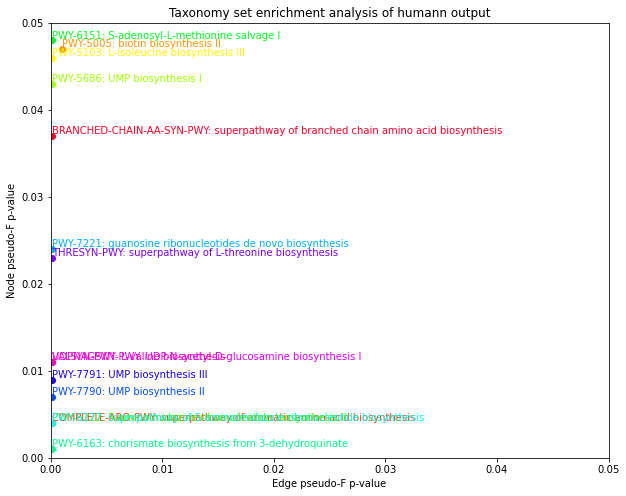

In [60]:
n = sig_path.shape[0]
cmap = plt.cm.gist_rainbow
colors = cmap(np.linspace(0., 1., n))
plt.figure(figsize=(10,8))
plt.xlim([0,0.05])
plt.ylim([0,0.05])
for i in range(n) :
    s,n,e = sig_path.iloc[i,:]
    c = matplotlib.colors.rgb2hex(colors[i])
    plt.scatter(e,n,color= c)
    plt.text(e,n,s,fontsize = 10,color = c,rotation=0,horizontalalignment='left',verticalalignment='bottom')  
plt.ylabel('Node pseudo-F p-value')
plt.xlabel('Edge pseudo-F p-value')
plt.title('Taxonomy set enrichment analysis of humann output')
plt.savefig(output_path + 'Humann-tsea-scatterplot-cross-threshold.png',dpi = 300)    

## Functions

### Network module

In [11]:
from scipy.stats import spearmanr,scoreatpercentile

###calculate z score
def zscore_dict(df) :
    n = df.shape[0]
    corr_z_dict = dict()
    for col in range(n-1) :
        for row in range(col+1,n) :
            name = (df.index[col],df.index[row])
            t1 = df.iloc[col,:]
            t2 = df.iloc[row,:]
            idx = (t1 + t2) > 0
            r,p = spearmanr(t1[idx],t2[idx])
            z = np.arctanh(r)
            corr_z_dict[name] = z
    return corr_z_dict

def zscore_percentile(corr_z_dict,pr) :
    z_list = list(corr_z_dict.values())
    percentile=scoreatpercentile(z_list, pr)
    return percentile

def zscore_hist(corr_z_dict,output_path,title) :

    z_list = list(corr_z_dict.values())
    df = pd.DataFrame({'z-score' : z_list})
    plt.figure(figsize=(8,5))
    sns.histplot(data = df,x = 'z-score',kde=True,stat='percent',bins=10,palette='Set2')
    plt.title(title)
    plt.savefig(output_path)

###network module
def create_corr_network(df) :
    n = df.shape[0]
    corr_z_dict = dict()
    for col in range(n-1) :
        for row in range(col+1,n) :
            name = (df.index[col],df.index[row])
            t1 = df.iloc[col,:]
            t2 = df.iloc[row,:]
            idx = (t1 + t2) > 0
            r,p = spearmanr(t1[idx],t2[idx])
            z = np.arctanh(r)
            corr_z_dict[name] = z

    g = nx.Graph()
    g.add_nodes_from(corr_z_dict.keys())
    #only add edge
    g.add_edges_from(corr_z_dict)
    #add z score of edge to graph object
    nx.set_edge_attributes(g,corr_z_dict,'weight')
    #add node attribute
    pv_lambda = lambda x : 100 * (sum(x > 0) / len(x))
    pv = list(map(pv_lambda,df.to_numpy()))
    pv_dict = dict(zip(df.index,pv))

    m_ab = df.mean(axis=1)
    mab_dict = dict(zip(df.index,m_ab))
    nx.set_node_attributes(g,pv_dict,name='Prevalence')
    nx.set_node_attributes(g,mab_dict,name='Mean abundance')

    return g


def filter_corr_network(g,threshold,pos_only=False,p_color = '#66c2a5',n_color='#fc8d62'):
    g_c = g.copy()
    color_dict = dict()
    #p_color = ImageColor.getcolor(p_color, "RGB")
    #n_color = ImageColor.getcolor(n_color, "RGB")
    for n1,n2,w in g_c.edges(data=True) :
        if pos_only :
            if w['weight'] < threshold :
                g.remove_edge(n1,n2)
            else :
                #add color attribute
                if w['weight'] > 0 :
                    color_dict[(n1,n2)] = p_color
                else :
                    color_dict[(n1,n2)] = n_color
        else :
            if abs(w['weight']) < threshold :
                g.remove_edge(n1,n2)
            else :
                #add color attribute
                if w['weight'] > 0 :
                    color_dict[(n1,n2)] = p_color
                else :
                    color_dict[(n1,n2)] = n_color
    nx.set_edge_attributes(g,color_dict,name='Color')
    #remove node degree = 1
    g_c = g.copy()
    for n,d in g_c.degree :
        if d < 2 :
            g.remove_node(n)

def sort_taxonomy_for_tsea(df) :
    n = df.shape[0]
    corr_z_dict = dict()
    for col in range(n-1) :
        for row in range(col+1,n) :
            name = (df.index[col],df.index[row])
            t1 = df.iloc[col,:]
            t2 = df.iloc[row,:]
            idx = (t1 + t2) > 0
            r,p = spearmanr(t1[idx],t2[idx])
            z = np.arctanh(r)
            corr_z_dict[name] = z
    df = pd.DataFrame({'Name' : corr_z_dict.keys(),'z-score' : corr_z_dict.values()}).sort_values(by='z-score',ascending=False)
    return list(df['Name'].values)

def subgraph(g,candidate,attr) :
    g_c = g.copy()
    cl = list(nx.get_node_attributes(g,attr).values())
    nl = list(g.nodes())
    for i in range(len(cl)) :
        if cl[i] != candidate :
            g_c.remove_node(nl[i])
    return g_c

### MCL module

In [12]:
### mcl module
def mcl_clustering(G) :

    matrix = nx.to_scipy_sparse_matrix(G,dtype=np.float32)
    result = mc.run_mcl(matrix)           
    clusters = mc.get_clusters(result)

    cluster_dict = dict()
    color_dict = dict()
    #set color for mcl clusters
    cmap = plt.cm.gist_rainbow
    n_cluster = len(clusters)
    colors = cmap(np.linspace(0., 1., n_cluster))

    node_list = list(G.nodes().keys())
    n_c = 0
    for i in range(len(clusters)) :
        if len(clusters[i]) < 2 :
            n = node_list[clusters[i][0]]
            cluster_dict[n] = 'No cluster'
            color_dict[n] = matplotlib.colors.rgb2hex(np.array([192/255,192/255,192/255,1]))
        else :
            for j in range(len(clusters[i])) :
                n = node_list[clusters[i][j]]
                cluster_dict[n] = "Cluster " + str(n_c)
                color_dict[n] = matplotlib.colors.rgb2hex(colors[n_c])
            n_c += 1
    nx.set_node_attributes(G,cluster_dict,'Cluster')
    nx.set_node_attributes(G,color_dict,'Color')

def number_of_mcl_cluster(g) :
    cl = list(nx.get_node_attributes(g,'Cluster').values())
    nl = list(g.nodes().keys())
    degree_list = [x[1] for x in g.degree]
    df = pd.DataFrame({'Species' : nl,'Cluster' : cl,'Degree' : degree_list})
    for i in list(set(df['Cluster'])) :
        num = sum(df['Cluster'] == i)
        print('Number of node in %s : %d' % (i,num))

### plot module

In [15]:
### plot module
def plot_corr_network(G,title,fig_output,fontsize=None,figsize = (20,12)) :

    plt.figure(figsize = figsize)
    #pos = nx.spring_layout(G,k = 4 / sqrt(G.order()))
    pos = nx.spring_layout(G)
    #pos = nx.multipartite_layout(G,subset_key='Cluster')
    #plot node
    node_color_list = nx.get_node_attributes(G,'Color').values()
    nx.draw_networkx_nodes(G,pos,node_color=node_color_list,alpha=0.8,node_size = [v[1] ** 3 for v in G.degree]) 
    species = list(pos.keys())
    for idx in range(len(pos)) :
        s = species[idx]
        x = pos[s][0]
        y = pos[s][1]
        if fontsize == None :
            plt.text(x,y,s,fontsize = G.degree[s],horizontalalignment='center',verticalalignment='center')  
        else :
            plt.text(x,y,s,fontsize = fontsize,horizontalalignment='center',verticalalignment='bottom')
    #plot edge
    edge_color = nx.get_edge_attributes(G,'Color').values()
    nx.draw_networkx_edges(G,pos,edge_color=edge_color)
    #plot legend
    node_cluser_list = nx.get_node_attributes(G,'Cluster').values()
    legend_dict = dict(zip(node_cluser_list,node_color_list))
    
    for cl,col in legend_dict.items() :
        plt.plot([],[],color = col,label = cl)
    
    plt.legend()
    plt.title(title,fontsize = 15)
    plt.savefig(fig_output)
    plt.show()

def degree_barplot(G,title,fig_output) :
    
    n_node = len(G.nodes())
    d_array = np.empty(n_node,dtype=int)
    n_array = np.empty(n_node,dtype=object)
    idx = 0
    for n,d in G.degree() :
        n_array[idx] = n
        d_array[idx] = d
        idx += 1
    plot_df = pd.DataFrame({'Species' : n_array,'Degree' : d_array})
    plot_df = plot_df.sort_values(by='Degree',ascending=False)
    plt.figure(figsize=(15,6))
    sns.barplot(data=plot_df,x='Species',y='Degree')
    plt.xticks(rotation=90)
    plt.title(title)
    plt.savefig(fig_output,dpi=300)

def node_scatter_plot(G,df,label,title,fig_output,xlabel,ylabel,measure='pv') :
    s = list(G.nodes)
    df = df.loc[s,:]
    if measure == 'pv' :
        pv_lambda = lambda x : 100 * ( sum(x>0) / len(x))
        x = list(map(pv_lambda,df.loc[:,label].to_numpy()))
        y = list(map(pv_lambda,df.loc[:,label==False].to_numpy()))
    elif measure == 'mab' :
        x = df.loc[:,label].mean(axis=1)
        y = df.loc[:,label == False].mean(axis=1)
    plt.scatter(x = x,y=y,c=y,cmap='rainbow')
    mi= min(min(x),min(y))
    ma = max(max(x),max(y))
    plt.plot([0,ma],[0,ma], 'r-')

    if measure == 'pv' :
        plt.xlim([mi-5,ma+5])
        plt.ylim([mi-5,ma+5])
    elif measure == 'mab' :
        plt.xlim([mi-0.05,ma+0.05])
        plt.ylim([mi-0.05,ma+0.05])
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.savefig(fig_output)
    plt.show()

def node_scatter_subplot(G,df,label,title,fig_output,xlabel,ylabel) :
    s = list(G.nodes)
    df = df.loc[s,:]
    f, (ax1, ax2) = plt.subplots(1, 2,figsize = (11,5))

    pv_lambda = lambda x : 100 * ( sum(x>0) / len(x))
    pv_x = list(map(pv_lambda,df.loc[:,label].to_numpy()))
    pv_y = list(map(pv_lambda,df.loc[:,label==False].to_numpy()))
    ab_x = df.loc[:,label].mean(axis=1)
    ab_y = df.loc[:,label == False].mean(axis=1)
    ###prevalence
    ax1.scatter(x = pv_x,y=pv_y,c=pv_y,cmap='rainbow')
    pv_mi= min(min(pv_x),min(pv_y))
    pv_ma = max(max(pv_x),max(pv_y))
    ax1.plot([0,pv_ma],[0,pv_ma], 'r-')

    ax1.set_xlim([pv_mi-5,pv_ma+5])
    ax1.set_ylim([pv_mi-5,pv_ma+5])
    ax1.set_xlabel('Prevalence in ' + xlabel)
    ax1.set_ylabel('Prevalence in ' + ylabel)
    ###mean abundance
    ax2.scatter(x = ab_x,y=ab_y,c=ab_y,cmap='rainbow')
    ab_mi= min(min(ab_x),min(ab_y))
    ab_ma = max(max(ab_x),max(ab_y))
    ax2.plot([0,ab_ma],[0,ab_ma], 'r-')
    ax2.set_xlim([ab_mi-0.05,ab_ma+0.05])
    ax2.set_ylim([ab_mi-0.05,ab_ma+0.05])
    ax2.set_xlabel('Mean abundance in ' + xlabel)
    ax2.set_ylabel('Mean abundance in ' + ylabel)
       
    f.suptitle(title)
    f.tight_layout()
    plt.savefig(fig_output)
    plt.show()

### Plot

In [9]:
g = create_corr_network(candidate_df)
filter_corr_network(g,0.25,pos_only=True)
mcl_clustering(g)
#plot_corr_network(g,'Co-expression network for candidate species',  output_path + 'tmp.png',figsize = (15,8))
#degree_barplot(g,'Degree of candidate species in co-expression network',  output_path + 'tmp.png')

In [ ]:
g_c = subgraph(g,attr='Cluster',candidate='Cluster 7')
plot_corr_network(g_c,'Co-expression network for candidate species (Streptococcus)', output_path + 'co-expression-cluster0.png',figsize = (15,8),fontsize=12)
l  = np.where(metadata['Diagnosis'] == 'MCI',True,False)
node_scatter_subplot(g_c,candidate_df,l,'Cluster 0 (Streptococcus) ',output_path + 'tmp.png','MCI','normal')

### TSEA

In [13]:
from GSEA import taxonomy_enrich_analysis,enrich_score,permutation
###pesudo code
tsea_output =  '/home/bruce1996/data/MCI/tsea/'
deseq_output = '/home/bruce1996/ssd/mci_deseq_res.txt'
deseq_df = pd.read_csv(deseq_output,sep='\t',index_col=0).sort_values(by='log2FoldChange',ascending=False)

tsea = taxonomy_enrich_analysis(deseq_output=deseq_df,metaphlan_output=meta_df,humann_index=None,graph=g,taxonomy=None)
node_df = tsea.TSEA(mode='Node',sorted=False).sort_values(by='Pathway')
edge_df = tsea.TSEA(mode='Edge',sorted=False).sort_values(by='Pathway')

df = pd.DataFrame({'Name' : node_df['Pathway'],'Node-pseudo-F' : node_df['p-value'],'Edge-pseudo-F' : edge_df['p-value']})
#df.to_csv(tsea_output + 'overall_positive_corr_tsea_result.txt',sep='\t')

taxonomy list length : 410
Calculate enrichment score of 1 / 10  pathway : Cluster 1
TSEA of pathway : Cluster 1 cost 0.60 s
Calculate enrichment score of 2 / 10  pathway : Cluster 0
TSEA of pathway : Cluster 0 cost 0.01 s
Calculate enrichment score of 3 / 10  pathway : Cluster 9
TSEA of pathway : Cluster 9 cost 0.01 s
Calculate enrichment score of 4 / 10  pathway : Cluster 3
TSEA of pathway : Cluster 3 cost 0.01 s
Calculate enrichment score of 5 / 10  pathway : Cluster 5
TSEA of pathway : Cluster 5 cost 0.01 s
Calculate enrichment score of 6 / 10  pathway : Cluster 8
TSEA of pathway : Cluster 8 cost 0.01 s
Calculate enrichment score of 7 / 10  pathway : Cluster 7
TSEA of pathway : Cluster 7 cost 0.01 s
Calculate enrichment score of 8 / 10  pathway : Cluster 4
TSEA of pathway : Cluster 4 cost 0.01 s
Calculate enrichment score of 9 / 10  pathway : Cluster 2
TSEA of pathway : Cluster 2 cost 0.01 s
Calculate enrichment score of 10 / 10  pathway : Cluster 6
TSEA of pathway : Cluster 6 cost

/home/bruce1996/repo/Microbiome_health_indicator/GSEA.py:110: RuntimeWarning: divide by zero encountered in arctanh
  z = np.arctanh(r)


taxonomy list length : 83845
Calculate enrichment score of 1 / 10  pathway : Cluster 1
TSEA of pathway : Cluster 1 cost 2.00 s
Calculate enrichment score of 2 / 10  pathway : Cluster 0
TSEA of pathway : Cluster 0 cost 2.01 s
Calculate enrichment score of 3 / 10  pathway : Cluster 9
TSEA of pathway : Cluster 9 cost 2.01 s
Calculate enrichment score of 4 / 10  pathway : Cluster 3
TSEA of pathway : Cluster 3 cost 2.00 s
Calculate enrichment score of 5 / 10  pathway : Cluster 5
TSEA of pathway : Cluster 5 cost 2.00 s
Calculate enrichment score of 6 / 10  pathway : Cluster 8
TSEA of pathway : Cluster 8 cost 2.01 s
Calculate enrichment score of 7 / 10  pathway : Cluster 7
TSEA of pathway : Cluster 7 cost 2.00 s
Calculate enrichment score of 8 / 10  pathway : Cluster 4
TSEA of pathway : Cluster 4 cost 2.01 s
Calculate enrichment score of 9 / 10  pathway : Cluster 2
TSEA of pathway : Cluster 2 cost 2.00 s
Calculate enrichment score of 10 / 10  pathway : Cluster 6
TSEA of pathway : Cluster 6 co

In [17]:
nx.get_node_attributes(g,'Cluster')
cluster_list = list(set(nx.get_node_attributes(g,'Cluster').values()))
cluster_list.remove('No cluster')
for c in cluster_list :
    g_sub = subgraph(g,attr='Cluster',candidate=c)
    if len(g_sub.node()) < 10 :
        pass
    else :
        represent_s,max_degree = sorted(g.degree, key=lambda x: x[1], reverse=True)[0]
        title = 'Co-expression network for' + ' ' + c + ' ' + represent_s
        file_name = output_path + 'co-expression-network' + '-' + represent_s + '.png'
        plot_corr_network(g_sub,title,file_name,figsize = (15,8),fontsize=12)
        node_scatter_subplot(g_sub,candidate_df,l,'Cluster 0 (Streptococcus) ',output_path + 'tmp.png','MCI','normal')

### main function

In [37]:
from GSEA import taxonomy_enrich_analysis,enrich_score,permutation

def main() :
    
    tsea_output =  '/home/bruce1996/data/MCI/tsea/'
    output_path = '/home/bruce1996/data/pr/0711/'
    deseq_output = '/home/bruce1996/ssd/mci_deseq_res.txt'
    deseq_df = pd.read_csv(deseq_output,sep='\t',index_col=0)
    metaphlan_output = "/home/bruce1996/nvme2/mci_for_adlasso/data/MCI_species_relative_abundance.txt"
    meta_df = pd.read_csv(metaphlan_output,sep = '\t',index_col=0)
    metadata = pd.read_csv('/home/bruce1996/nvme2/mci_for_adlasso/data/MCI_sample_diagnosis.csv',sep = '\t',index_col=0)
    diagnosis_idx = np.where(metadata['Diagnosis'] == 'MCI',True,False)
    ### candidate species
    selected_df = pd.read_csv('/home/bruce1996/nvme2/mci_for_adlasso/MCI/selected_feature.txt',sep = '\t',header=None)
    selected_s = selected_df.iloc[:,0].values
    candidate_df = meta_df.loc[selected_s,:]

    condition = ['Overall','MCI','Normal']
    percentile = 90
    #node_num_dict = {'Overall' : 10,'MCI' : 5,'Normal' : 5}

    for con in condition :
        
        if con == 'Overall' :
            metaphlan = meta_df
            candidate = candidate_df
        elif con == 'MCI' :
            metaphlan = meta_df.loc[:,diagnosis_idx]
            candidate = candidate_df.loc[:,diagnosis_idx]
        elif con == 'Normal' :
            metaphlan = meta_df.loc[:,diagnosis_idx == False]
            candidate = candidate_df.loc[:,diagnosis_idx == False]

        g = create_corr_network(candidate)
        zscore_dict = nx.get_edge_attributes(g,'weight')
        percentile_threshold = zscore_percentile(zscore_dict,percentile)
        filter_corr_network(g,percentile_threshold,pos_only=True)
        mcl_clustering(g)
        plot_corr_network(g,con +' '+'co-expression network for candidate species',output_path + con + '-co-expression-network.png',figsize = (15,8))
        #### taxonomy set enrichment analysis
        tsea = taxonomy_enrich_analysis(deseq_output=deseq_df,metaphlan_output=metaphlan,humann_index=None,graph=g,taxonomy=None)
        node_df = tsea.TSEA(mode='Node',sorted=False).sort_values(by='Pathway')
        edge_df = tsea.TSEA(mode='Edge',sorted=False).sort_values(by='Pathway')
        tsea_df = pd.DataFrame({'Name' : node_df['Pathway'],'Node-pseudo-F' : node_df['p-value'],'Edge-pseudo-F' : edge_df['p-value']})
        tsea_df.index = tsea_df['Name'].values
        tsea_df.to_csv(tsea_output + con + '-TSEA-output.txt',sep='\t')

        ###plot sub network
        nx.get_node_attributes(g,'Cluster')
        cluster_list = list(set(nx.get_node_attributes(g,'Cluster').values()))
        cluster_list.remove('No cluster')
        for c in cluster_list :
            g_sub = subgraph(g,attr='Cluster',candidate=c)
            print("Cluster : {c} node pseudo F : {node}, edge pseudo F : {edge}".format(c=c,node = tsea_df.loc[c,'Node-pseudo-F'],edge =tsea_df.loc[c,'Edge-pseudo-F'] ))
            if tsea_df.loc[c,'Node-pseudo-F'] < 0.05 and tsea_df.loc[c,'Edge-pseudo-F'] < 0.05 :

                represent_s,_ = sorted(g_sub.degree, key=lambda x: x[1], reverse=True)[0]
                #stat of subnetwork member
                sub_s = list(g_sub.nodes())
                sub_deseq_df = deseq_df.loc[sub_s,:].copy()
                df_file_name = output_path + con + '-' + 'co-expression-subnetwork' + '-' + represent_s + '.txt'
                sub_deseq_df.to_csv(df_file_name,sep='\t')
                ##plot subnetwork
                subnetwork_title = con + ' ' + 'subnetwork for' + ' ' + c + ' ' + '('+ represent_s + ')'
                file_name = output_path + con + '-' + 'co-expression-subnetwork' + '-' + represent_s + '.png'
                plot_corr_network(g_sub,subnetwork_title,file_name,figsize = (15,8),fontsize=12)
                if con == 'Overall' :
                    scatter_title = 'Subnetwork scatterplot for' + ' ' + c + ' ' + '('+ represent_s + ')'
                    scatter_name = output_path + 'Subnetwork scatterplot for' + ' ' + c + ' ' + '('+ represent_s + ')' + '.png'
                    node_scatter_subplot(g_sub,candidate,diagnosis_idx,scatter_title,scatter_name,'MCI','normal')
            else :
                pass


In [ ]:
main()

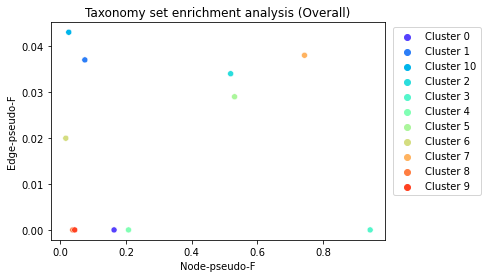

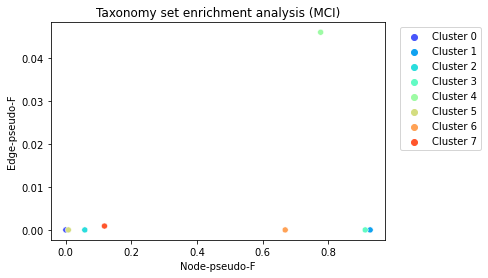

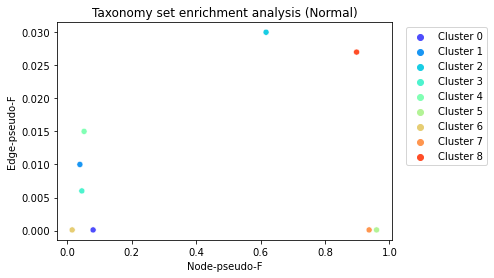

In [56]:
tsea_output = '/home/bruce1996/data/MCI/tsea/'
con = ['Overall','MCI','Normal']
for c in con :
    name = tsea_output + c + '-TSEA-output.txt'
    df = pd.read_csv(name,sep='\t',index_col=0)
    edge_p = df['Edge-pseudo-F'].values
    sns.scatterplot(data = df,x = 'Node-pseudo-F',y='Edge-pseudo-F',hue = 'Name',palette='rainbow')
    plt.title('Taxonomy set enrichment analysis ' + '(' + c + ')')
    plt.legend(bbox_to_anchor=(1.3, 1))
    plt.savefig(output_path + c + '-TSEA-scatterplot.png',bbox_inches='tight',dpi = 300)
    plt.show()

### import kgml file

In [24]:
kgml  = '/home/bruce1996/data/MCI/kegg/bbb00780.kgml'

In [25]:
from Bio.KEGG.KGML import KGML_parser
#https://biopython.org/docs/1.76/api/Bio.KEGG.KGML.KGML_pathway.html

pathway = KGML_parser.read(open(kgml, 'r'))
component_list = np.empty(29,dtype= object)
for idx,c in enumerate(pathway.compounds) :
    component_list[idx] = c.name

29
cpd:C02656


In [114]:
kgml2com_dict = dict()
component_dict = dict()
kgml_path = '/home/bruce1996/data/MCI/kegg/'
kgml_list = os.listdir(kgml_path)

n=0
for f in kgml_list :
    if f[-4:] != 'kgml' :
        pass
    else :
        n += 1
        print('Parse %d st kgml file : %s' % (n,f))
        map_name = 'map' + f[3:]
        filename = kgml_path + f
        ##parse kgml file
        pathway = KGML_parser.read(open(filename, 'r'))
        n_component = len(pathway.compounds)
        component_list = np.empty(n_component,dtype= object)
        for idx,c in enumerate(pathway.compounds) :
            component_list[idx] = c.name
            if c.name not in component_dict.keys() :
                component_dict[c.name] = 0
            else :
                component_dict[c.name] += 1

        if map_name not in kgml2com_dict.keys() :
            kgml2com_dict[map_name] = component_list


Parse 1 st kgml file : lcx00650.kgml
Parse 2 st kgml file : lpl00780.kgml
Parse 3 st kgml file : lfe01110.kgml
Parse 4 st kgml file : lca00380.kgml
Parse 5 st kgml file : lca00361.kgml
Parse 6 st kgml file : lfe00680.kgml
Parse 7 st kgml file : lpl00460.kgml
Parse 8 st kgml file : lre00630.kgml
Parse 9 st kgml file : lre00660.kgml
Parse 10 st kgml file : lpl00030.kgml
Parse 11 st kgml file : lre00520.kgml
Parse 12 st kgml file : lpl00521.kgml
Parse 13 st kgml file : lca00430.kgml
Parse 14 st kgml file : lca03430.kgml
Parse 15 st kgml file : lre02024.kgml
Parse 16 st kgml file : lrh03010.kgml
Parse 17 st kgml file : lcx00780.kgml
Parse 18 st kgml file : lac01212.kgml
Parse 19 st kgml file : lcx00541.kgml
Parse 20 st kgml file : bcoa00020.kgml
Parse 21 st kgml file : lcx00770.kgml
Parse 22 st kgml file : lac01502.kgml
Parse 23 st kgml file : lre01212.kgml
Parse 24 st kgml file : lpl03430.kgml
Parse 25 st kgml file : lca01120.kgml
Parse 26 st kgml file : lre00350.kgml
Parse 27 st kgml fil

In [46]:
map_list = [x.split('.')[0] for x in kgml2com_dict.keys()]

In [116]:
component_dict

{'cpd:C03046': 17,
 'cpd:C01769': 17,
 'cpd:C00810': 25,
 'cpd:C03044': 17,
 'cpd:C06010': 70,
 'cpd:C00022': 402,
 'cpd:C00042': 162,
 'cpd:C00122': 148,
 'cpd:C01384': 44,
 'cpd:C00497': 17,
 'cpd:C02527': 17,
 'cpd:C00246': 17,
 'cpd:C00136': 79,
 'cpd:C01412': 26,
 'cpd:C00877': 100,
 'cpd:C02411': 34,
 'cpd:C03058': 17,
 'cpd:C02630': 25,
 'cpd:C00026': 189,
 'cpd:C00024': 326,
 'cpd:C00356': 44,
 'cpd:C00332': 120,
 'cpd:C00164': 67,
 'cpd:C01089': 17,
 'cpd:C04546': 17,
 'cpd:C03561': 52,
 'cpd:C01144': 99,
 'cpd:C02331': 17,
 'cpd:C06143': 17,
 'cpd:C00989': 35,
 'cpd:C00232': 79,
 'cpd:C00334': 65,
 'cpd:C00025': 218,
 'cpd:C06142': 35,
 'cpd:C06144': 17,
 'cpd:C06145': 8,
 'cpd:C06146': 8,
 'cpd:C00741': 17,
 'cpd:C11062': 35,
 'cpd:C00091': 123,
 'cpd:C20657': 17,
 'cpd:C21390': 35,
 'cpd:C00207': 17,
 'cpd:C17530': 17,
 'cpd:C00132': 53,
 'cpd:C01845': 17,
 'cpd:C20783': 17,
 'cpd:C02656': 26,
 'cpd:C01063': 52,
 'cpd:C01092': 26,
 'cpd:C01909': 26,
 'cpd:C01037': 26,
 'cpd